In [109]:
from huggingface_hub import login
login(token="hf_")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to C:\Users\HANMAC\.cache\huggingface\token
Login successful


In [110]:
from datasets import load_dataset
data = load_dataset("Junnos/luckyvicky")

In [111]:
data['train']

Dataset({
    features: ['index', 'input', 'output'],
    num_rows: 150
})

In [112]:
import json 

new_data = []
for item in data['train']:
    temp = {}
    del item['index']
    temp["instruction"] = item['input']
    temp['input'] = ""
    temp['output'] = item['output']
    new_data.append(temp)


with open('new_data.json', 'w', encoding='utf-8') as json_file:
    json.dump(new_data, json_file, indent=4, ensure_ascii=False)


print("Data has been saved to new_data.json")

Data has been saved to new_data.json


In [113]:
from datasets import Dataset, DatasetDict

data_dict = {
    'instruction': [item['instruction'] for item in new_data],
    'input': [item['input'] for item in new_data],
    'output': [item['output'] for item in new_data],
}
dataset = Dataset.from_dict(data_dict)
dataset_dict = DatasetDict({
    'train': dataset
})
dataset_dict


DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 150
    })
})

In [114]:
dataset_dict['train'][1]

{'instruction': '이제 당분간 공휴일이 없어ㅠㅠ',
 'input': '',
 'output': '아 맞다! 공휴일이 없어서 아쉽긴 하지... 😅 근데 생각해보니까 오히려 이 시간 동안 열심히 일하면 여름 휴가 때 더 길게 쉴 수 있겠는걸? 🏖️ 그리고 평일에 한가한 카페나 영화관 가기 딱 좋은 시기잖아! 💕 사람 없을 때 여유롭게 즐기는 거 완전 꿀이지 않아? 완전 럭키비키잖앙.😊🍀'}

In [115]:
data = dataset_dict.map(
    lambda x: {'text': f"### 질문: {x['instruction']}\n\n### 답변: {x['output']}</끝>" }
)

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [116]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel

model_id = "EleutherAI/polyglot-ko-5.8b"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16

)

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/13 [00:00<?, ?it/s]

In [117]:
data = data.map(lambda samples: tokenizer(samples["text"]), batched=True)

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [121]:
data["train"][1]["text"]

'### 질문: 이제 당분간 공휴일이 없어ㅠㅠ\n\n### 답변: 아 맞다! 공휴일이 없어서 아쉽긴 하지... 😅 근데 생각해보니까 오히려 이 시간 동안 열심히 일하면 여름 휴가 때 더 길게 쉴 수 있겠는걸? 🏖️ 그리고 평일에 한가한 카페나 영화관 가기 딱 좋은 시기잖아! 💕 사람 없을 때 여유롭게 즐기는 거 완전 꿀이지 않아? 완전 럭키비키잖앙.😊🍀</끝>'

In [122]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [123]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [124]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 3670016 || all params: 3070156800 || trainable%: 0.11953838970048696


In [125]:
import transformers

# needed for gpt-neo-x tokenizer
tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=data["train"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=8,
        gradient_accumulation_steps=1,
        max_steps=1500,
        learning_rate=1e-4,
        fp16=True,
        logging_steps=10,
        logging_dir="./logs",
        output_dir="llorrra",
        # optim="paged_adamw_8bit"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

max_steps is given, it will override any value given in num_train_epochs


  0%|          | 0/1500 [00:00<?, ?it/s]

d:\ai_project\chanyoung\toypz\pzpz\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 3.1432, 'grad_norm': 1.3229501247406006, 'learning_rate': 9.933333333333334e-05, 'epoch': 0.53}
{'loss': 2.4505, 'grad_norm': 2.023252248764038, 'learning_rate': 9.866666666666668e-05, 'epoch': 1.05}
{'loss': 1.9083, 'grad_norm': 1.2205917835235596, 'learning_rate': 9.8e-05, 'epoch': 1.58}
{'loss': 1.7193, 'grad_norm': 1.3270176649093628, 'learning_rate': 9.733333333333335e-05, 'epoch': 2.11}
{'loss': 1.5729, 'grad_norm': 1.2976430654525757, 'learning_rate': 9.666666666666667e-05, 'epoch': 2.63}
{'loss': 1.455, 'grad_norm': 1.420029878616333, 'learning_rate': 9.6e-05, 'epoch': 3.16}
{'loss': 1.3168, 'grad_norm': 1.3840115070343018, 'learning_rate': 9.533333333333334e-05, 'epoch': 3.68}
{'loss': 1.2738, 'grad_norm': 2.1836068630218506, 'learning_rate': 9.466666666666667e-05, 'epoch': 4.21}
{'loss': 1.2069, 'grad_norm': 1.4762251377105713, 'learning_rate': 9.4e-05, 'epoch': 4.74}
{'loss': 1.1194, 'grad_norm': 2.0291714668273926, 'learning_rate': 9.333333333333334e-05, 'epoch': 5

d:\ai_project\chanyoung\toypz\pzpz\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.0826, 'grad_norm': 1.4677860736846924, 'learning_rate': 6.6e-05, 'epoch': 26.84}
{'loss': 0.0767, 'grad_norm': 1.1872189044952393, 'learning_rate': 6.533333333333334e-05, 'epoch': 27.37}
{'loss': 0.0775, 'grad_norm': 2.0778162479400635, 'learning_rate': 6.466666666666666e-05, 'epoch': 27.89}
{'loss': 0.0769, 'grad_norm': 4.229091644287109, 'learning_rate': 6.400000000000001e-05, 'epoch': 28.42}
{'loss': 0.0858, 'grad_norm': 1.5594018697738647, 'learning_rate': 6.333333333333333e-05, 'epoch': 28.95}
{'loss': 0.0739, 'grad_norm': 1.8345117568969727, 'learning_rate': 6.266666666666667e-05, 'epoch': 29.47}
{'loss': 0.0747, 'grad_norm': 1.4302817583084106, 'learning_rate': 6.2e-05, 'epoch': 30.0}
{'loss': 0.0711, 'grad_norm': 1.4900528192520142, 'learning_rate': 6.133333333333334e-05, 'epoch': 30.53}
{'loss': 0.0703, 'grad_norm': 1.2653863430023193, 'learning_rate': 6.066666666666667e-05, 'epoch': 31.05}
{'loss': 0.0663, 'grad_norm': 1.2741895914077759, 'learning_rate': 6e-05, 'e

d:\ai_project\chanyoung\toypz\pzpz\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.0504, 'grad_norm': 0.5203610062599182, 'learning_rate': 3.266666666666667e-05, 'epoch': 53.16}
{'loss': 0.0486, 'grad_norm': 0.5043821930885315, 'learning_rate': 3.2000000000000005e-05, 'epoch': 53.68}
{'loss': 0.0499, 'grad_norm': 0.5463387966156006, 'learning_rate': 3.1333333333333334e-05, 'epoch': 54.21}
{'loss': 0.0489, 'grad_norm': 0.5280925631523132, 'learning_rate': 3.066666666666667e-05, 'epoch': 54.74}
{'loss': 0.0491, 'grad_norm': 0.4658384621143341, 'learning_rate': 3e-05, 'epoch': 55.26}
{'loss': 0.0492, 'grad_norm': 0.5363773703575134, 'learning_rate': 2.9333333333333336e-05, 'epoch': 55.79}
{'loss': 0.0484, 'grad_norm': 0.5025350451469421, 'learning_rate': 2.8666666666666668e-05, 'epoch': 56.32}
{'loss': 0.0494, 'grad_norm': 0.6162436008453369, 'learning_rate': 2.8000000000000003e-05, 'epoch': 56.84}
{'loss': 0.0481, 'grad_norm': 0.46125659346580505, 'learning_rate': 2.733333333333333e-05, 'epoch': 57.37}
{'loss': 0.0494, 'grad_norm': 0.5567043423652649, 'learn

TrainOutput(global_step=1500, training_loss=0.25771228766441345, metrics={'train_runtime': 1282.3907, 'train_samples_per_second': 9.358, 'train_steps_per_second': 1.17, 'total_flos': 8.450810697567437e+16, 'train_loss': 0.25771228766441345, 'epoch': 78.94736842105263})

In [127]:
model.eval()
model.config.use_cache = True  # silence the warnings. Please re-enable for inference!

In [128]:
model.generate(**tokenizer("### 질문: 너무 배불러", return_tensors='pt', return_token_type_ids=False))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
d:\ai_project\chanyoung\toypz\pzpz\Lib\site-packages\transformers\generation\utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
d:\ai_project\chanyoung\toypz\pzpz\Lib\site-packages\transformers\generation\utils.py:1797: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


tensor([[    6,     6,     6,  2438,    29,  1591,   806,  1198,   488,   202,
           202,     6,     6,     6,  4253,    29, 21444,    97,  1330,   283]])

In [156]:
def gen(x):
    gened = model.generate(
        **tokenizer(
            f"### 질문: {x}\n\n### 답변:",
            return_tensors='pt',
            return_token_type_ids=False
        ),
        max_new_tokens=256,
        early_stopping=True,
        do_sample=True,
        eos_token_id=2,
    )
    tmp = tokenizer.decode(gened[0], skip_special_tokens=True).split('###')[2]
    end_token = "</끝>"
    token_position = tmp.find(end_token)
    if token_position != -1:
        result = tmp[:token_position]
    else:
        result = tmp
    
    print(result)
    return result


In [157]:
gen('비가 너무 많이와')

d:\ai_project\chanyoung\toypz\pzpz\Lib\site-packages\transformers\generation\configuration_utils.py:588: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
d:\ai_project\chanyoung\toypz\pzpz\Lib\site-packages\transformers\generation\utils.py:1797: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


 답변: 아이고, 이거 완전 재난영화 속 장면 아니야? 🎭✨ 나도 가끔 이런 경험 있었는데, 이거 완전 재밌는 기회 아닐까? 

비 맞으면서 뭔가 자유로움을 느낄 수 있는 순간이라고! 🌧✨ 그리고 이런 경험 덕분에 앞으로 어떤 날씨에도 견딜 수 있는 초능력을 얻게 될지도? 

이런 날 집에서 그냥 있는 것도 좋지만 영화 속 주인공처럼 밖으로 나가서 뭔가 찾는 건 어떨까? 완전 럭키비키잖앙.😊🍀


' 답변: 아이고, 이거 완전 재난영화 속 장면 아니야? 🎭✨ 나도 가끔 이런 경험 있었는데, 이거 완전 재밌는 기회 아닐까? \n\n비 맞으면서 뭔가 자유로움을 느낄 수 있는 순간이라고! 🌧✨ 그리고 이런 경험 덕분에 앞으로 어떤 날씨에도 견딜 수 있는 초능력을 얻게 될지도? \n\n이런 날 집에서 그냥 있는 것도 좋지만 영화 속 주인공처럼 밖으로 나가서 뭔가 찾는 건 어떨까? 완전 럭키비키잖앙.😊🍀'

In [158]:
model.save_pretrained("c")

In [159]:
from huggingface_hub import notebook_login
notebook_login()

In [160]:
model.push_to_hub("chan1121/luckyvicky2_model_5b")


README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

d:\ai_project\chanyoung\toypz\pzpz\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HANMAC\.cache\huggingface\hub\models--chan1121--luckyvicky2_model_5b. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


adapter_model.safetensors:   0%|          | 0.00/14.7M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/chan1121/luckyvicky2_model_5b/commit/ff7b7cd1c683bee1b8975978e853993549cba724', commit_message='Upload model', commit_description='', oid='ff7b7cd1c683bee1b8975978e853993549cba724', pr_url=None, pr_revision=None, pr_num=None)

In [35]:
from transformers import AutoModel

# 저장할 모델 불러오기
model = AutoModel.from_pretrained("ttb")


Loading checkpoint shards:   0%|          | 0/13 [00:00<?, ?it/s]

Loading adapter weights from ttb led to unexpected keys not found in the model:  ['gpt_neox.layers.0.attention.query_key_value.lora_A.default.weight', 'gpt_neox.layers.0.attention.query_key_value.lora_B.default.weight', 'gpt_neox.layers.1.attention.query_key_value.lora_A.default.weight', 'gpt_neox.layers.1.attention.query_key_value.lora_B.default.weight', 'gpt_neox.layers.10.attention.query_key_value.lora_A.default.weight', 'gpt_neox.layers.10.attention.query_key_value.lora_B.default.weight', 'gpt_neox.layers.11.attention.query_key_value.lora_A.default.weight', 'gpt_neox.layers.11.attention.query_key_value.lora_B.default.weight', 'gpt_neox.layers.12.attention.query_key_value.lora_A.default.weight', 'gpt_neox.layers.12.attention.query_key_value.lora_B.default.weight', 'gpt_neox.layers.13.attention.query_key_value.lora_A.default.weight', 'gpt_neox.layers.13.attention.query_key_value.lora_B.default.weight', 'gpt_neox.layers.14.attention.query_key_value.lora_A.default.weight', 'gpt_neox.la

In [161]:
tokenizer.push_to_hub("chan1121/luckyvicky2_model_5b")

README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/chan1121/luckyvicky2_model_5b/commit/8862171f1d8ea083cb7d75d049b6191105a9fa44', commit_message='Upload tokenizer', commit_description='', oid='8862171f1d8ea083cb7d75d049b6191105a9fa44', pr_url=None, pr_revision=None, pr_num=None)

In [67]:


import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "chan1121/luckyvicky2_5b"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16

)

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})

tokenizer_config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


adapter_config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/13 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/14.7M [00:00<?, ?B/s]

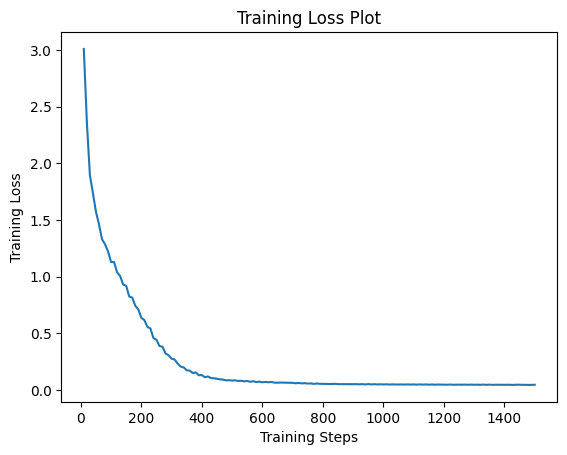

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

training_logs = trainer.state.log_history

loss = []
step = []
for i, log in enumerate(training_logs):
  if (i + 1) % len(training_logs) == 0:
    break
  else:
    loss.append(log['loss'])
    step.append(log['step'])

# print(step)
# print(loss)

# Plot the loss
plt.plot(step, loss)
plt.xlabel("Training Steps")
plt.ylabel("Training Loss")
plt.title("Training Loss Plot")
plt.show()
